In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# For progress bars
from tqdm.notebook import tqdm

# Setting plot style
sns.set(style="whitegrid")
%matplotlib inline


In [2]:
# Define the base directory for Malaria dataset
base_dir = '/kaggle/input/cell-images-for-detecting-malaria/cell_images'

# Define class names for classification
classes = ['Parasitized', 'Uninfected']


In [3]:
# Initialize lists to hold image paths and labels
image_paths = []
labels = []

# Populate lists with image paths and labels
for cls in classes:
    class_dir = os.path.join(base_dir, cls)
    for img_filename in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, img_filename))
        labels.append(cls)

# Map class names to integer labels
label_mapping = {cls: idx for idx, cls in enumerate(classes)}
mapped_data = [(img, label_mapping[cls]) for img, cls in zip(image_paths, labels)]

# Convert to DataFrame for inspection
mapped_df = pd.DataFrame(mapped_data, columns=['image_path', 'label'])
print("Sample data:")
print(mapped_df.head())
print(f"Total images: {len(mapped_df)}")


Sample data:
                                          image_path  label
0  /kaggle/input/cell-images-for-detecting-malari...      0
1  /kaggle/input/cell-images-for-detecting-malari...      0
2  /kaggle/input/cell-images-for-detecting-malari...      0
3  /kaggle/input/cell-images-for-detecting-malari...      0
4  /kaggle/input/cell-images-for-detecting-malari...      0
Total images: 27560


In [4]:
from PIL import UnidentifiedImageError

class MalariaCellDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = [img for img in image_paths if img.endswith(('.png', '.jpg', '.jpeg'))]  # Only keep valid image files
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            # Load image
            image = Image.open(self.image_paths[idx]).convert('RGB')
            
            # Apply transformations
            if self.transform:
                image = self.transform(image)
                
            label = self.labels[idx]
            return image, label
        
        except UnidentifiedImageError:
            # Skip unreadable files and proceed to the next item
            print(f"Skipping unreadable file: {self.image_paths[idx]}")
            return self.__getitem__((idx + 1) % len(self))  # Use modulo to prevent index out of range


In [5]:
# Define image transformations for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define transformations for validation and testing
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [6]:
# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Calculate split sizes
total_size = len(mapped_data)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

print(f"Total samples: {total_size}")
print(f"Training samples: {train_size}")
print(f"Validation samples: {val_size}")
print(f"Testing samples: {test_size}")

# Shuffle and split data
from sklearn.model_selection import train_test_split

# First split: Train and Temp (Val + Test)
train_data, temp_data = train_test_split(
    mapped_data,
    test_size=(1 - train_ratio),
    random_state=42,
    stratify=[x[1] for x in mapped_data]  # Stratify based on labels
)

# Second split: Validation and Test
val_size_adjusted = val_ratio / (val_ratio + test_ratio)  # Adjust validation size
val_data, test_data = train_test_split(
    temp_data,
    test_size=(1 - val_size_adjusted),
    random_state=42,
    stratify=[x[1] for x in temp_data]
)

# Separate paths and labels for each set
train_paths, train_labels = zip(*train_data)
val_paths, val_labels = zip(*val_data)
test_paths, test_labels = zip(*test_data)

print(f"Training samples: {len(train_paths)}")
print(f"Validation samples: {len(val_paths)}")
print(f"Testing samples: {len(test_paths)}")

# Compute class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights = torch.tensor(class_weights, dtype=torch.float)
print(f"Class Weights: {class_weights}")


Total samples: 27560
Training samples: 19292
Validation samples: 4134
Testing samples: 4134
Training samples: 19291
Validation samples: 4134
Testing samples: 4135
Class Weights: tensor([1.0001, 0.9999])


In [7]:
# Create Dataset instances
train_dataset = MalariaCellDataset(train_paths, train_labels, transform=train_transform)
val_dataset = MalariaCellDataset(val_paths, val_labels, transform=val_test_transform)
test_dataset = MalariaCellDataset(test_paths, test_labels, transform=val_test_transform)

# Define batch size and number of workers
batch_size = 32
num_workers = 4

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print(f"Number of batches - Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")


Number of batches - Train: 603, Val: 130, Test: 130


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


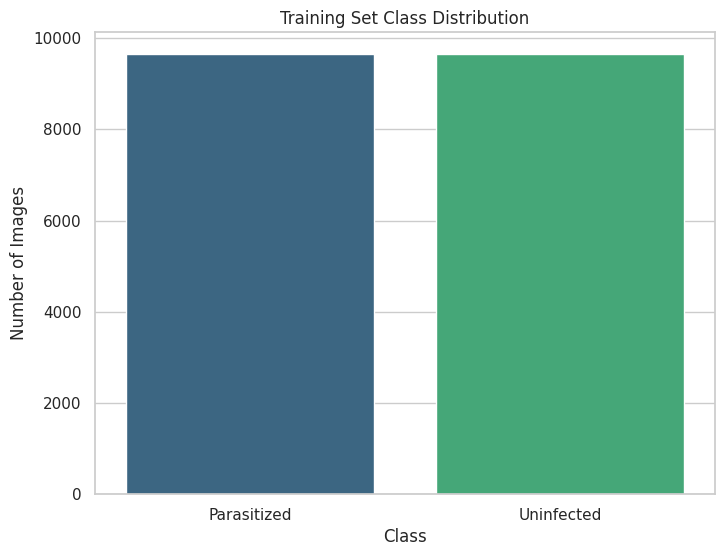

In [8]:
# Count class distribution in training set
train_label_counts = pd.Series(train_labels).value_counts().sort_index()

# Create a bar plot for class distribution
plt.figure(figsize=(8,6))
sns.barplot(x=classes, y=train_label_counts.values, palette='viridis')
plt.title('Training Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


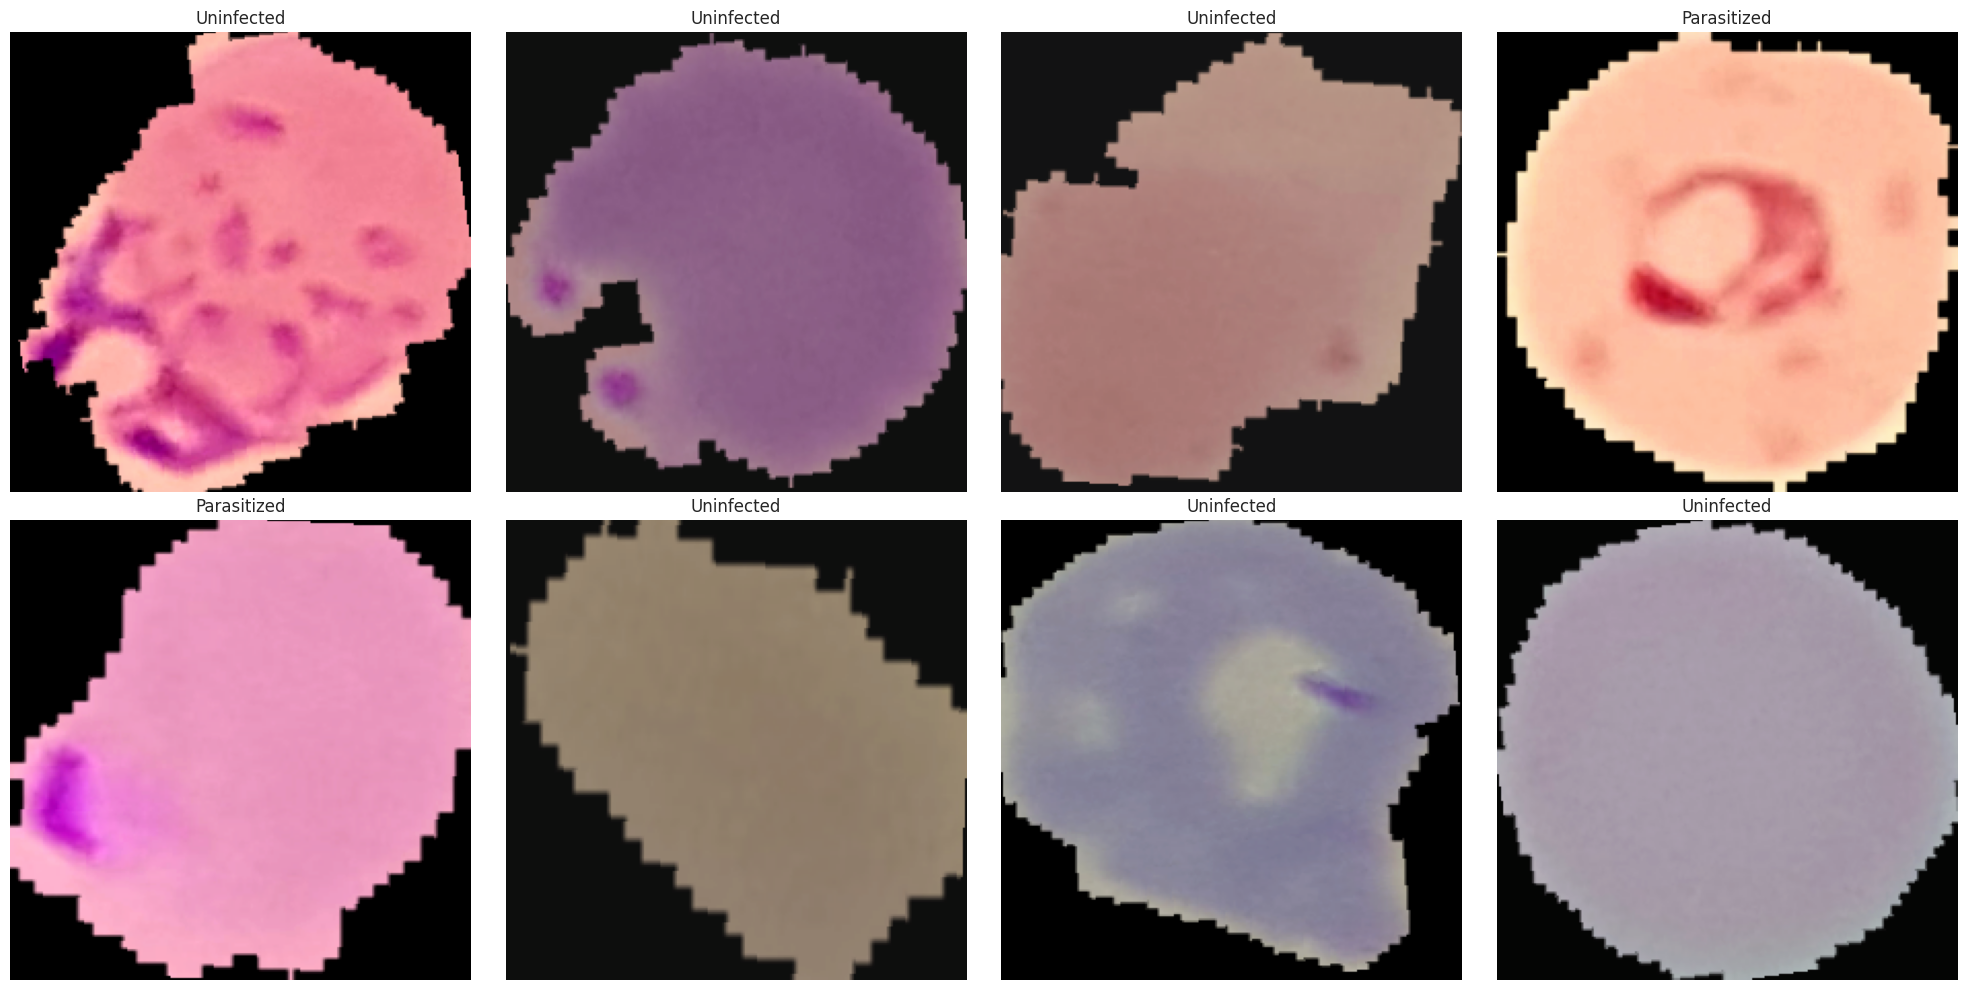

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def imshow(img, title=None):
    """
    Displays a tensor as an image.
    
    Args:
        img (Tensor): Image tensor.
        title (str, optional): Title for the image.
    """
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img * np.array([0.229, 0.224, 0.225]) + 
                 np.array([0.485, 0.456, 0.406]), 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

def show_batch(loader, classes, num_images=8):
    """
    Displays a batch of images with their labels.
    
    Args:
        loader (DataLoader): DataLoader to fetch the batch.
        classes (list): List of class names.
        num_images (int): Number of images to display.
    """
    images, labels = next(iter(loader))
    
    # Calculate grid dimensions
    num_rows = (num_images + 3) // 4  # Ensure enough rows for `num_images`
    plt.figure(figsize=(20, num_rows * 5))
    
    for i in range(num_images):
        plt.subplot(num_rows, 4, i + 1)  # Arrange images in a `num_rows x 4` grid
        imshow(images[i])
        plt.title(classes[labels[i].item()])
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Show a batch from the training set
show_batch(train_loader, classes, num_images=8)


In [10]:
class ResNet50Baseline(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50Baseline, self).__init__()
        self.resnet = models.resnet50(pretrained=False)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)
    
    def forward(self, x):
        x = self.resnet(x)
        return x


In [11]:
import torch
import torch.nn as nn
from torchvision import models

class SmallCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SmallCell, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(input_size, input_size // 4),
            nn.ReLU(),
            nn.Linear(input_size // 4, 4 * hidden_size)
        )

    def forward(self, x):
        return self.seq(x)

class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, nlayers, dropout=0.1):
        super(LSTMCell, self).__init__()
        self.nlayers = nlayers
        self.dropout = nn.Dropout(p=dropout)

        ih, hh = [], []
        for i in range(nlayers):
            if i == 0:
                ih.append(SmallCell(input_size, hidden_size))
                hh.append(SmallCell(hidden_size, hidden_size))
            else:
                ih.append(nn.Linear(hidden_size, 4 * hidden_size))
                hh.append(nn.Linear(hidden_size, 4 * hidden_size))
        self.w_ih = nn.ModuleList(ih)
        self.w_hh = nn.ModuleList(hh)

    def forward(self, input, hidden):
        hy, cy = [], []
        for i in range(self.nlayers):
            hx, cx = hidden[0][i], hidden[1][i]
            gates = self.w_ih[i](input) + self.w_hh[i](hx)
            i_gate, f_gate, c_gate, o_gate = gates.chunk(4, 1)
            i_gate = torch.sigmoid(i_gate)
            f_gate = torch.sigmoid(f_gate)
            c_gate = torch.tanh(c_gate)
            o_gate = torch.sigmoid(o_gate)
            ncx = (f_gate * cx) + (i_gate * c_gate)
            nhx = o_gate * torch.tanh(ncx)
            cy.append(ncx)
            hy.append(nhx)
            input = self.dropout(nhx)
        hy, cy = torch.stack(hy, 0), torch.stack(cy, 0)
        return hy, cy

class Attention(nn.Module):
    def __init__(self, channel):
        super(Attention, self).__init__()
        self.lstm = LSTMCell(channel, channel, 1)
        self.global_avg = nn.AdaptiveAvgPool2d((1, 1))
        self.relu = nn.ReLU()

    def forward(self, x):
        org = x
        seq = self.global_avg(x)
        seq = seq.view(seq.size(0), seq.size(1))
        ht = torch.zeros((1, seq.size(0), seq.size(1)), device=x.device)
        ct = torch.zeros((1, seq.size(0), seq.size(1)), device=x.device)
        ht, ct = self.lstm(seq, (ht, ct))
        x = x * (ht[-1].view(ht.size(1), ht.size(2), 1, 1))
        x += org
        x = self.relu(x)
        return x

class ResNet50WithDIANet(nn.Module):
    def __init__(self, num_classes=2, pretrained=False):
        super(ResNet50WithDIANet, self).__init__()
        self.resnet = models.resnet50(pretrained=pretrained)
        self.dianet_block = Attention(channel=2048)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)
        
        # Apply DIANet attention block
        x = self.dianet_block(x)
        
        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.resnet.fc(x)
        return x



In [12]:
# Define model type options: 'baseline', 'se', 'eca', 'gct', 'fcanet', 'dianet'
model_type = 'dianet'  # Options: 'baseline', 'se', 'eca', 'gct', 'fcanet', 'dianet'

# Number of classes
num_classes = len(classes)

# Model selection based on model_type
if model_type == 'baseline':
    model = ResNet50Baseline(num_classes=num_classes)
elif model_type == 'se':
    model = ResNet50WithSE(num_classes=num_classes)
elif model_type == 'eca':
    model = ResNet50WithECA(num_classes=num_classes)
elif model_type == 'gct':
    model = ResNet50WithGCT(num_classes=num_classes)
elif model_type == 'fcanet':
    model = ResNet50WithFcaNet(num_classes=num_classes)
elif model_type == 'dianet':
    model = ResNet50WithDIANet(num_classes=num_classes)
elif model_type == 'splitattn':
    model = ResNet50WithSplitAttention(num_classes=num_classes)
else:
    raise ValueError("Invalid model type selected.")

# Move the model to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(model)

# Define loss function with class weights
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Define learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet50WithDIANet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(


In [13]:
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=25):
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in tqdm(dataloader, desc=phase.capitalize()):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
        
        print()
    
    print(f'Best Validation Acc: {best_acc:.4f}')
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

# Define number of epochs
num_epochs = 25

# Train the model
trained_model, history = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=num_epochs)


Epoch 1/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.7111 Acc: 0.5135


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.6788 Acc: 0.5351

Epoch 2/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.7125 Acc: 0.5137


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.6775 Acc: 0.5806

Epoch 3/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.7040 Acc: 0.5240


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.6883 Acc: 0.5230

Epoch 4/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.7026 Acc: 0.5209


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.6655 Acc: 0.6086

Epoch 5/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.6976 Acc: 0.5368


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.6838 Acc: 0.5131

Epoch 6/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.6800 Acc: 0.5944


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.4857 Acc: 0.9243

Epoch 7/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.6721 Acc: 0.6134


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.5204 Acc: 0.9207

Epoch 8/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.6693 Acc: 0.6218


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.5177 Acc: 0.8926

Epoch 9/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.6645 Acc: 0.6282


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.5225 Acc: 0.9446

Epoch 10/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.6621 Acc: 0.6340


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.4448 Acc: 0.9461

Epoch 11/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.6539 Acc: 0.6431


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.4670 Acc: 0.9521

Epoch 12/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.6531 Acc: 0.6430


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.4788 Acc: 0.9536

Epoch 13/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.6514 Acc: 0.6438


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.4661 Acc: 0.9550

Epoch 14/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.6515 Acc: 0.6447


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.4688 Acc: 0.9516

Epoch 15/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.6514 Acc: 0.6434


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.4693 Acc: 0.9540

Epoch 16/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.6511 Acc: 0.6447


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.4385 Acc: 0.9552

Epoch 17/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.6502 Acc: 0.6447


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.4743 Acc: 0.9552

Epoch 18/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.6510 Acc: 0.6449


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.4511 Acc: 0.9548

Epoch 19/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.6496 Acc: 0.6442


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.4742 Acc: 0.9523

Epoch 20/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.6506 Acc: 0.6435


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.4631 Acc: 0.9562

Epoch 21/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.6491 Acc: 0.6436


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.4610 Acc: 0.9560

Epoch 22/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.6482 Acc: 0.6460


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.4607 Acc: 0.9552

Epoch 23/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.6486 Acc: 0.6448


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.4590 Acc: 0.9567

Epoch 24/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.6482 Acc: 0.6448


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.4597 Acc: 0.9567

Epoch 25/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.6487 Acc: 0.6445


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.4580 Acc: 0.9569

Best Validation Acc: 0.9569


Testing:   0%|          | 0/130 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

 Parasitized       0.97      0.95      0.96      2068
  Uninfected       0.95      0.97      0.96      2067

    accuracy                           0.96      4135
   macro avg       0.96      0.96      0.96      4135
weighted avg       0.96      0.96      0.96      4135



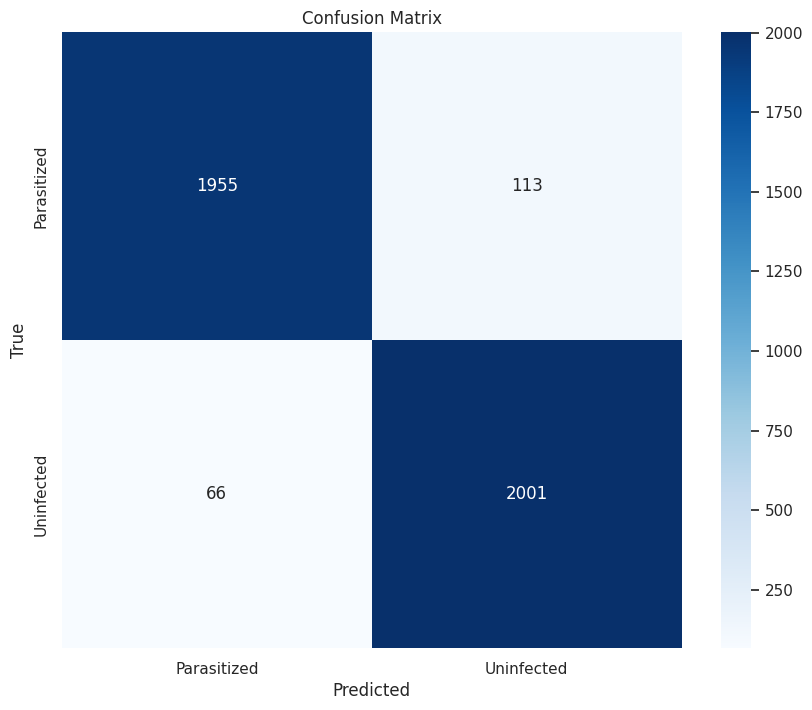

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, dataloader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate the model on the test set
evaluate_model(trained_model, test_loader, classes)


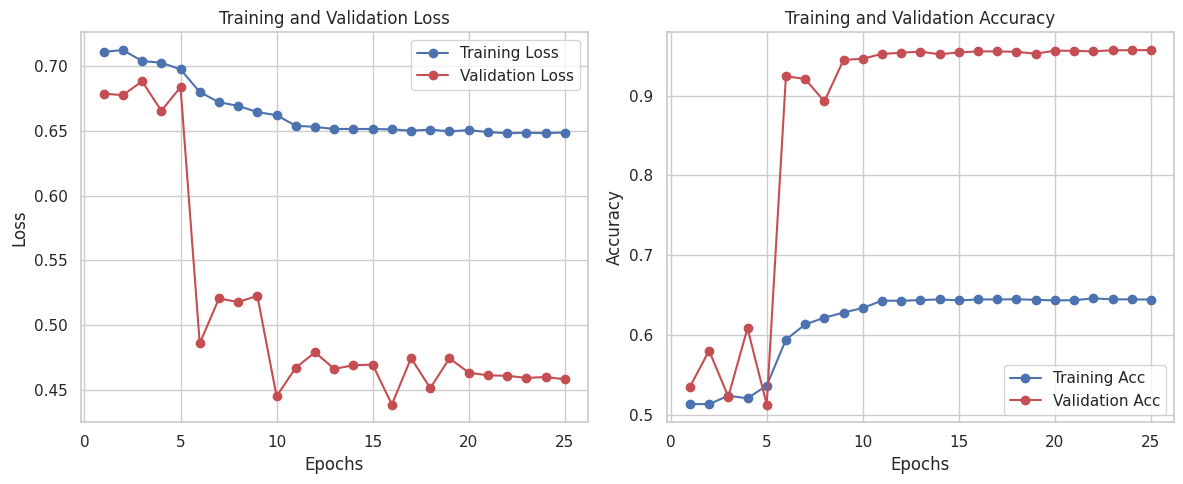

In [15]:
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot Loss
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_acc'], 'bo-', label='Training Acc')
    plt.plot(epochs, history['val_acc'], 'ro-', label='Validation Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_history(history)


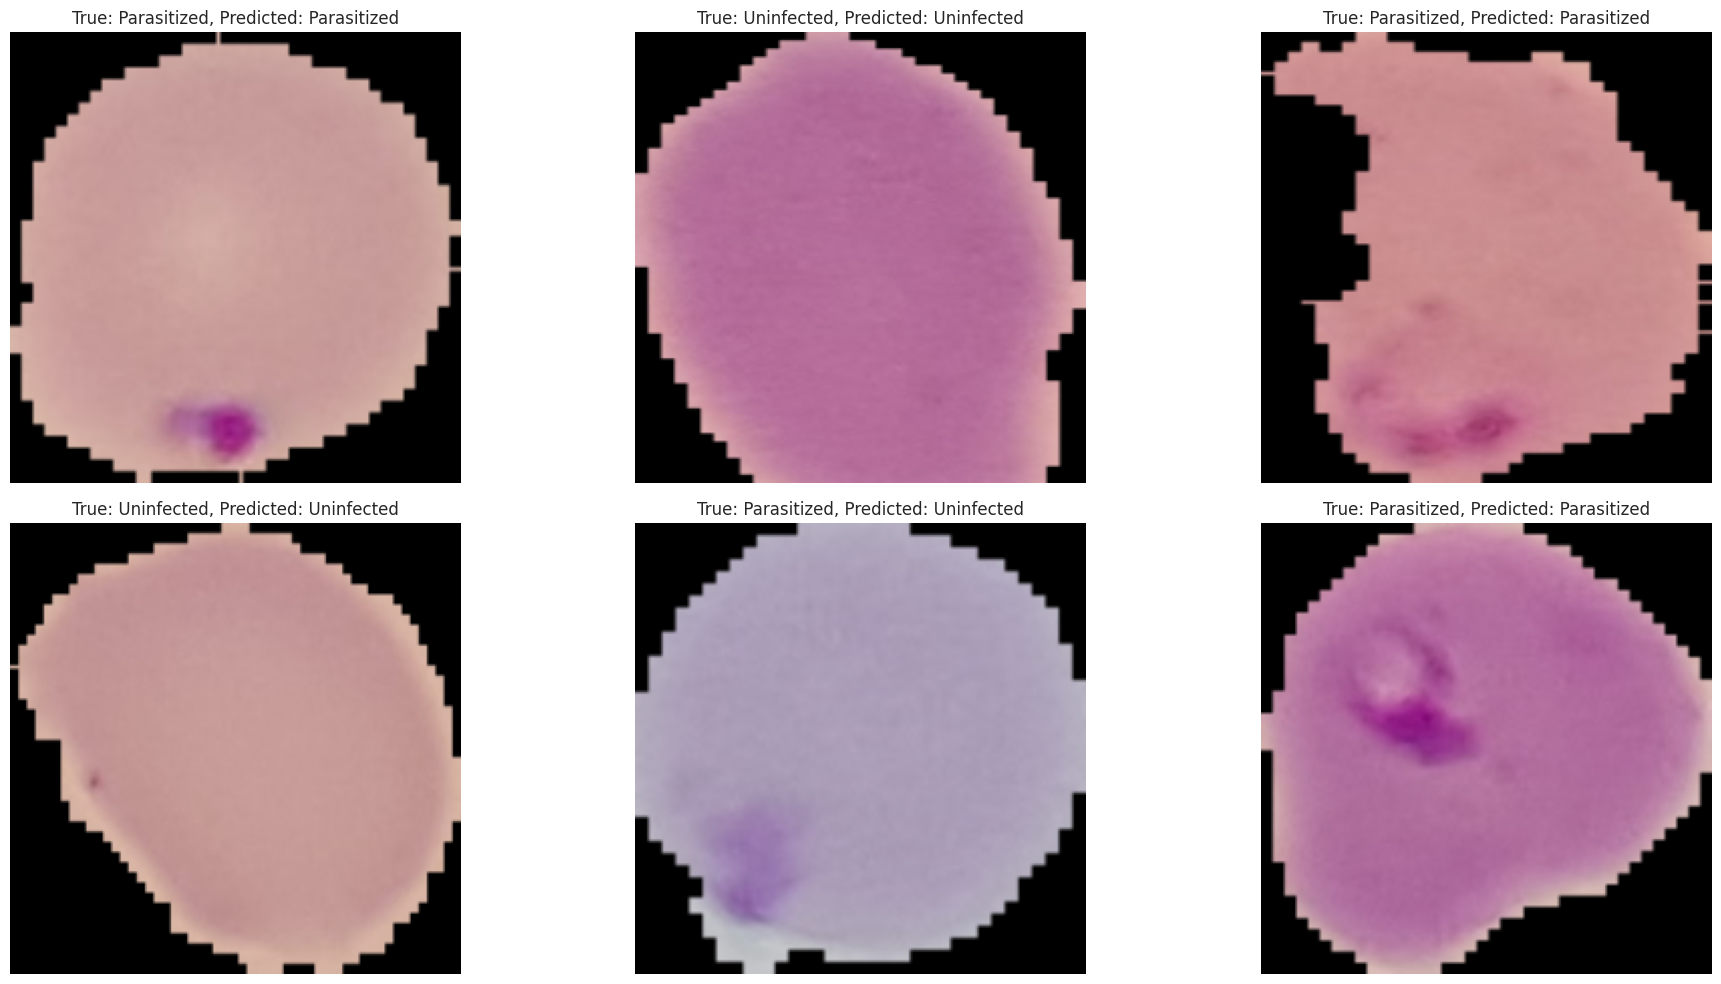

In [16]:
def visualize_predictions(model, dataloader, classes, num_images=6):
    model.eval()
    images, labels = next(iter(dataloader))
    images = images.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
    
    images = images.cpu().numpy()
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()
    
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        plt.subplot(2, num_images//2, i+1)
        img = images[i].transpose((1, 2, 0))
        img = np.clip(img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
        plt.imshow(img)
        plt.title(f"True: {classes[labels[i]]}, Predicted: {classes[preds[i]]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize sample predictions
visualize_predictions(trained_model, test_loader, classes, num_images=6)
